Quadratic Assignment Problem
================================

The quadratic assignment problem was first introduced in 1957 by Koopmans and Beckmann to solve facility location problems which call for minimizing the cost proportional to the flow of goods between the facilities. This is a well studied problem.

QAP seeks to mimimize a cost function based on fixed quantities (weights) between pairs of one set, $P$, and distances between pairs of another set $L$ when each member of $L$ is assigned to one member of $P$.

Simple Example
-----------------

This first example is a synthetic problem with a five facilities and five locations. The first consideration is the planned flow between the facilities. The table below shows the quantity of material planned to be moved from one facility to the other. Facility 1 sends to facilities 2, 3 and 5. Facilites 2 and 3 send to facilities 4 and 5. Facility 4 doesn't send to any other faciilty and facility 5 sends one unit to facility 4.

| Source Facility / Destination Facility | Facility 1 | Facility 2 | Faclity 3 | Facility 4 | Facility 5 |
|---|---|---|---|---|---|
| **Facility 1**| | 5 | 8 |  | 1 |
| **Facility 2** | | | | 10 | 15 |
| **Facility 3** | | | | 13 | 18 |
| **Facility 4** | | | | | |
| **Facility 5** | | | | 1 | |

The second consideration is the distance between locations. The distances in this example are symmetric.

| Distances | Location 1 | Location 2 | Location 3 | Location 4 | Location 5 |
|---|---|---|---|---|---|
| **Location 1** | 0 | 8.54 | 6.4 | 10 | 8.94 |
| **Location 2** | 8.54 | 0 | 4.47 | 5.39 | 6.49 |
| **Location 3** | 6.4 | 4.47 | 0 | 3.61 | 3 |
| **Location 4** | 10 | 5.39 | 3.61 | 0 | 2 |
| **Location 5** | 8.94 | 6.49 | 3 | 2 | 0 |

The third consideration is the cost of building a facility at a location.

| Facility / Location | Location 1| Location 2 | Location 3 | Location 4 | Location 5 |
|---|---|---|---|---|---|
| **Facility 1**| 2 | 3 | 6 | 3 | 7 |
| **Facility 2** | 3 | 9 | 2 | 5 | 9 |
| **Facility 3** | 2 | 6 | 4 | 1 | 2 |
| **Facility 4** | 7 | 5 | 8 | 5 | 7 |
| **Facility 5** | 1 | 9 | 2 | 9 | 2 |

The outcomes in this example range from optimal to 166% of optimal. This implies a considerable benefit to performing the optimization.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from qci_client import QciClient
from helpers import plot_qap, assignment_from_solution, create_qap_objective, create_qap_constraints, find_index_of_nearest
from data import mip_obj_vals

Here is the data described in the tables above.

In [2]:

A = np.array([[0, 5, 8, 0, 1],
                [0, 0, 0, 10, 15],
                [0, 0, 0, 13, 18],
                [0, 0, 0, 0, 0.],
                [0, 0, 0, 1, 0.]])
B = np.array([[0, 8.54, 6.4, 10, 8.94],
                [8.54, 0, 4.47, 5.39, 6.49],
                [6.4, 4.47, 0, 3.61, 3.0],
                [10, 5.39, 3.61, 0, 2.0],
                [8.94, 6.49, 3.0, 2.0, 0.]])
C = np.array([[2, 3, 6, 3, 7],
                [3, 9, 2, 5, 9],
                [2, 6, 4, 1, 2],
                [7, 5, 8, 5, 7],
                [1, 9, 2, 9, 2.]])
n = 5
num_variables = 25

This code creates the objective matrix from the three input matrices, then uploads the data to the API.

In [3]:
qciclient = QciClient()

In [4]:
objective_file = create_qap_objective(A, B, C, n, num_variables)
obj_file_id = qciclient.upload_file(data=objective_file)["file_id"]

Here we start a client for the API and upload the objective matrix.

The constraint matrix is built using only the number of facilities/locations. It is the same across all problems of the same size, independent of the other input data.

This code builds the constraint data and uploads two files, one for the left hand side and another for the right.

In [5]:
constraints_file, rhs_file = create_qap_constraints(n)
constraint_file_id = qciclient.upload_file(data=constraints_file)["file_id"]
rhs_file_id = qciclient.upload_file(data=rhs_file)["file_id"]

This is where we make the job request. The request is asynchronous. The job status can be checked by referencing the job id. When the job status no longer reports `RUNNING`, the response can be retrieved. The response contains job execution and results data.

In [6]:
alpha = 105.625
job_params = {"sampler_type": "eqc1", "alpha": alpha, "n_samples": 5}
body = qciclient.build_job_body(job_type="sample-constraint", job_params=job_params,
    constraints_file_id=constraint_file_id, objective_file_id=obj_file_id,
    rhs_file_id=rhs_file_id, job_name=f"QAP Demo",
    job_tags=[])

response = qciclient.process_job(job_type="sample-constraint", job_body=body, wait=False)

Job submitted job_id='6579d04766705e945c78fb11'-: 2023/12/13 08:39:51


In [7]:
job_id = response["job_id"]
job_id

'6579d04766705e945c78fb11'

In [8]:
qciclient.get_job_status(job_id=job_id)

{'job_id': '6579d04766705e945c78fb11', 'status': 'RUNNING'}

This loop waits for the job to complete.

In [11]:
import time
while qciclient.get_job_status(job_id=job_id)["status"] == "RUNNING":
    time.sleep(10)

In [12]:
response = qciclient.get_job_response(job_id=job_id, job_type="sample-constraint")

The response includes a reference to a results file, which is where the solution samples and energies are found. 

In [14]:
results_file_id = response["results"]["file_id"]
results = qciclient.get_file_whole(file_id=results_file_id)

In [15]:
# results = response["results"]
sample = np.array(results["samples"])

In [16]:
results["energies"], results["counts"]

([330.6398242187506, 331.7902148437506], [4, 1])

We convert the bit vector of length 25 into an array of assignments of length 5 and plot the assignments in a bi-partite graph.

In [17]:
assignment = assignment_from_solution(sample[0], n)
assignment

[0, 3, 2, 1, 4]

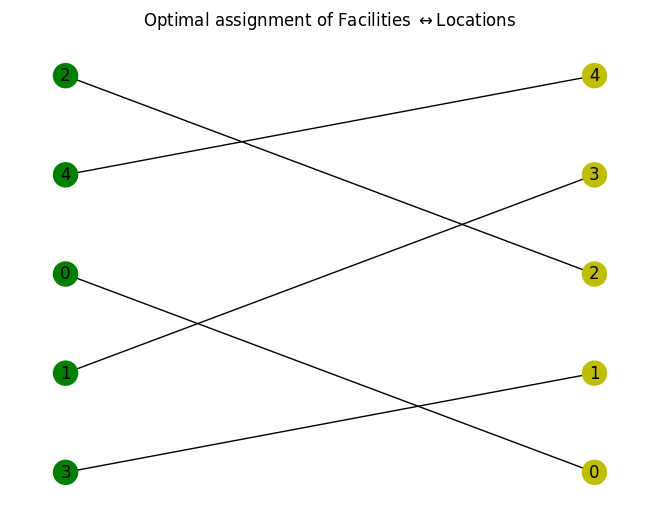

In [18]:
plot_qap(assignment)

These values were obtained by enumerating all feasible solutions and evaluating the objective function. 

Results
========

In this plot, the objective values of all feasible solutions are shown with the objective value of the solution found by **Dirac-1**. Notice the result is the lowest possible objective value.

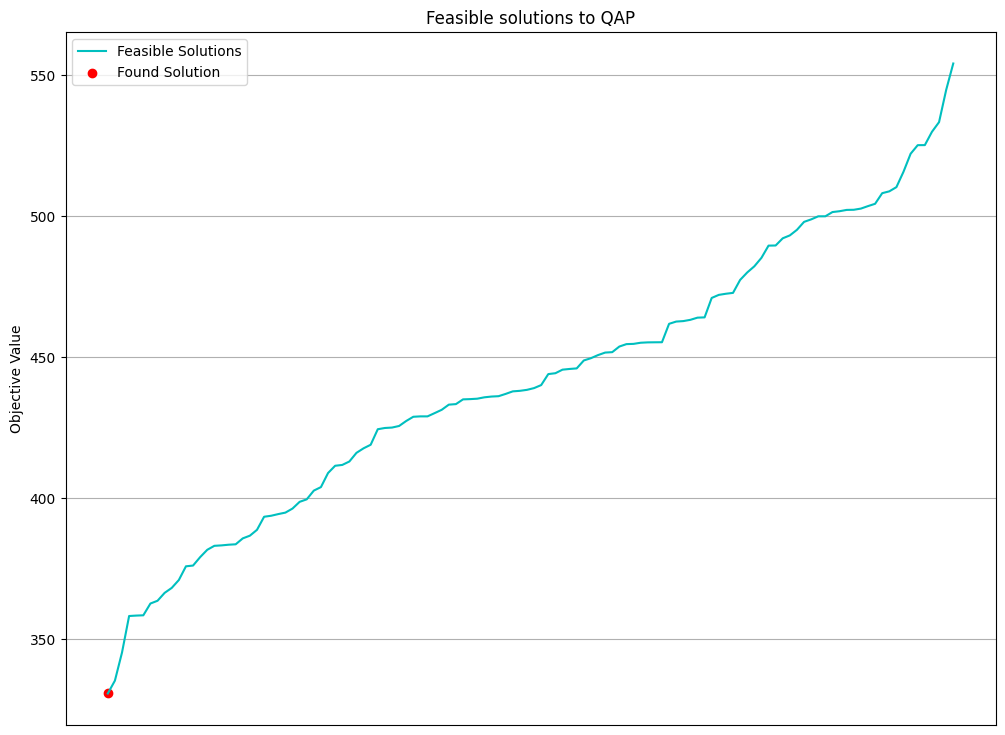

In [19]:
plt.figure(figsize=(12, 9))
ser1 = plt.plot(mip_obj_vals, "c-", label="Feasible Solutions")
plt.title("Feasible solutions to QAP")
ax = plt.gca()
plt.xlabel("Feasible Solution")
ax.get_xaxis().set_visible(False)
plt.ylabel("Objective Value")
# ser2 = plt.plot([0, len(mip_obj_vals)-1], [results["energies"][0], results["energies"][0]], label="Found Solution")
obj_val = results["energies"][0]
idx = find_index_of_nearest(mip_obj_vals, obj_val)
ser2 = plt.scatter([idx], [obj_val], c="r", marker="o", label="Found Solution")
plt.legend()
plt.grid()